In [1]:
import pandas as pd
import numpy as n
import ROOT as R
#R.enableJSVis()
R.ROOT.EnableImplicitMT()

c1=R.TCanvas('c1','c1',900,700)

t=R.TLatex()
t.SetTextSize(0.04)

graphs={}

Welcome to JupyROOT 6.18/04


In [2]:
#few functions definition

logit=R.TF1("logit","[0]/(1+TMath::Exp(-[1]*(x-[2])))",0,100)
logit.SetParameter(0,100)
logit.SetParLimits(0,0,10000)
logit.SetParameter(1,3)
logit.SetParLimits(1,0.,50.)
logit.SetParameter(2,5)
logit.SetParLimits(2,0.,200.)

f=R.TF1("ff","TMath::Exp((x+[0])/[1])",0,100)
f.SetParameter(0,13)
f.SetParLimits(0,-100,100)
f.SetParameter(1,4.5)
f.SetParLimits(1,1.,6.)


def rebinGraph(g,r,assignError):
    n=g.GetN()
    g1=R.TGraphErrors()
    g1.SetName(g.GetName()+'_rebin%d'%r)
    ibin=0
    average_Y=0
    average_X=0
    sumw2=0
    nbin=0
    for i in range(n):
        ibin+=1
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        average_X+=x
        average_Y+=y
        erry=g.GetErrorY(i)
        if (erry>0):
            w2=1/(erry**2)
        else:
            w2=0.
        sumw2+=w2
        if (ibin>=r or i==n-1):
            average_Y=average_Y/ibin
            average_X=average_X/ibin
            if (sumw2>0):
                err_Y=R.TMath.Sqrt(1/sumw2)
            else:
                err_Y=0.
            err_X=float(ibin)/2.
            g1.SetPoint(nbin,average_X,average_Y)
            if (assignError):
                g1.SetPointError(nbin,err_X,err_Y)
            else:
                g1.SetPointError(nbin,0,0)
            nbin+=1
            ibin=0
            average_Y=0
            average_X=0
            sumw2=0
    return g1

def integralGraph(g,firstPoint,lastPoint=-1):
    if (lastPoint==-1):
        lastPoint=g.GetN()
    integral=0
    error=0
    for i in range(firstPoint,lastPoint):
        x,y=R.Double(0),R.Double(0)
        g.GetPoint(i,x,y)
        integral+=y
        error+=g.GetErrorY(i)*g.GetErrorY(i)
    return [integral,R.TMath.Sqrt(error)]

smooth=R.TGraphSmooth()
smooth1=R.TGraphSmooth()

In [3]:
#Official data from http://www.epiprev.it/sites/default/files/SISMG_COVID19_28032020.pdf
urlByTown = 'mortalita_settimanale_per_citta.csv'
dfByTown = pd.read_csv(urlByTown)

urlByTownDaily = 'mortalita_giornaliera_per_citta.csv'
dfByTownDaily = pd.read_csv(urlByTownDaily)

urlByTownAgeWeekly = 'mortalita_settimanale_byAge.csv'
dfByTownAgeWeekly = pd.read_csv(urlByTownAgeWeekly)

In [4]:
urlIstat = '~/Downloads/comuni_settimana.csv'
dfIstat = pd.read_csv(urlIstat)
dfIstat.tail()

,REG,PROV,COD_PROVCOM,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,DATA_INIZIO_DIFF,SETTIMANA,CLASSE_DI_ETA,MASCHI_2015,...,FEMMINE_2017,FEMMINE_2018,FEMMINE_2019,FEMMINE_2020,TOTALE_2015,TOTALE_2016,TOTALE_2017,TOTALE_2018,TOTALE_2019,TOTALE_2020
87823,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,01/03-07/03,75 anni e più,2,...,1,0,1,1,2,2,2,0,2,2
87824,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,08/03-14/03,75 anni e più,2,...,1,0,2,0,3,0,1,0,2,2
87825,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,15/03-21/03,75 anni e più,0,...,0,0,0,1,1,1,0,0,0,1
87826,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,22/03-28/03,75 anni e più,1,...,0,3,0,0,1,1,1,3,0,1
87827,20,111,111106,Sardegna,Sud Sardegna,Villasor,1 aprile,29/03-04/04,75 anni e più,0,...,0,0,1,0,0,0,0,0,1,1


In [5]:
dfByTown.tail()

,Town,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13
11,Roma,484,506,453,480,483,490,540,521.0,547.0
12,Bari,57,63,53,56,74,78,54,NaN,NaN
13,Potenza,7,12,8,12,16,8,18,NaN,NaN
14,Messina,53,48,65,56,50,49,61,NaN,NaN
15,Palermo,125,152,126,145,133,149,124,NaN,NaN


In [6]:
#Official data from Protezione Civile
urlByProvince = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
urlNational = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
urlByRegion = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'


dfByProvince = pd.read_csv(urlByProvince,na_filter = False)
dfNational = pd.read_csv(urlNational)
dfByRegion = pd.read_csv(urlByRegion)

lastDate=dfNational['data'][len(dfNational)-1]

#dfByProvince.head(5)
#dfNational.head(5)

print("Last data %s"%lastDate)

Last data 2020-04-17T17:00:00


In [7]:
df={}

provinces = n.unique(dfByTown['Town'])
for p in provinces:
    df[p]=dfByTown[dfByTown['Town']==p]
    df[p]=df[p].drop(columns=['Town'])
    df[p]=df[p].transpose()
    df[p].columns=['number_of_deaths']
    #df[p]=df[p].set_index('week')

dfDaily={}

provincesDaily = n.unique(dfByTownDaily['Town'])
for p in provincesDaily:
    dfDaily[p]=dfByTownDaily[dfByTownDaily['Town']==p]
    dfDaily[p]=dfDaily[p].drop(columns=['Town'])
    dfDaily[p]=dfDaily[p].transpose()
    dfDaily[p].columns=['number_of_deaths']
    dfDaily[p]['number_of_deaths']=dfDaily[p]['number_of_deaths'].astype(float)
    #print('---- %s ----'%p)
    #print(dfDaily[p].tail().to_string())

dfPCM={}

for p in provincesDaily:
    dfPCM[p]=dfByProvince[dfByProvince['denominazione_provincia']==p]

for p in n.unique(dfByRegion['denominazione_regione']):
    dfPCM[p]=dfByRegion[dfByRegion['denominazione_regione']==p]

population = pd.read_csv('italianPopulation.csv')
#population = population.set_index('Territory')
#population.colums=['population']


In [8]:
dfPCM['Piemonte'].tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
1041,2020-04-13T17:00:00,ITA,1,Piemonte,45.073274,7.680687,3344,379,3723,9042,12765,260,474,2543,1826,17134,69170,NaN,NaN
1062,2020-04-14T17:00:00,ITA,1,Piemonte,45.073274,7.680687,3395,367,3762,9293,13055,290,556,2708,1927,17690,71678,NaN,NaN
1083,2020-04-15T17:00:00,ITA,1,Piemonte,45.073274,7.680687,3338,366,3704,9491,13195,140,539,3019,2015,18229,75664,NaN,NaN
1104,2020-04-16T17:00:00,ITA,1,Piemonte,45.073274,7.680687,3418,346,3764,10019,13783,588,879,3231,2094,19108,80708,NaN,NaN
1125,2020-04-17T17:00:00,ITA,1,Piemonte,45.073274,7.680687,3266,333,3599,10399,13998,215,695,3634,2171,19803,86714,NaN,NaN


In [9]:
print(population.to_string())

                 Territory  Population
0                    Italy    60359546
1               Nord ovest    16093286
2                      Sud    13957942
3                Centro(I)    12016009
4                 Nord est    11652827
5                Lombardia    10060574
6                    Isole     6639482
7                    Lazio     5879082
8                 Campania     5801692
9                  Sicilia     4999891
10                  Veneto     4905854
11          Emilia Romagna     4459477
12                Piemonte     4356406
13                    Roma     4342212
14                  Puglia     4029053
15                 Toscana     3729641
16                  Milano     3250315
17                  Napoli     3084890
18                  Torino     2259523
19                Calabria     1947131
20                Sardegna     1639591
21                 Liguria     1550640
22                  Marche     1525271
23                 Abruzzo     1311580
24                 Bresci

In [10]:
regions=n.unique(dfByRegion['denominazione_regione'])
print(regions)

['Abruzzo' 'Basilicata' 'Calabria' 'Campania' 'Emilia-Romagna'
 'Friuli Venezia Giulia' 'Lazio' 'Liguria' 'Lombardia' 'Marche' 'Molise'
 'P.A. Bolzano' 'P.A. Trento' 'Piemonte' 'Puglia' 'Sardegna' 'Sicilia'
 'Toscana' 'Umbria' "Valle d'Aosta" 'Veneto']


In [11]:
graphs={}

#"Brescia","Torino","Milano","Genova","Aosta","Bari","Bologna","Bolzano","Messina","Palermo","Perugia","Potenza","Roma","Trento","Venezia","Verona"
#regions=[
#    'Lombardia',
#    'Piemonte',
#    'Liguria',
#    'Veneto',
#    'Lazio',
#]

townRegion={
    'Brescia':'Lombardia',
    'Milano':'Lombardia',
    'Torino':'Piemonte',
    'Genova':'Liguria',
    'Roma':'Lazio',
    'Bari':'Puglia',
    'Bologna':'Emilia-Romagna',
    'Messina':'Sicilia',
    'Palermo':'Sicilia',
    'Perugia':'Umbria',
    'Potenza':'Basilicata',
    'Venezia':'Veneto',
    'Aosta':"Valle d'Aosta",
    'Trento':"P.A. Trento",
    'Bolzano':"P.A. Bolzano",
    'Verona':'Veneto'
}

townPopulation={
    'Brescia':196670,
    'Milano':1.352E6,
    'Torino':886837,
    'Genova':583601,
    'Roma':2.873E6,
    'Bari':324198,
    'Bologna':388367,
    'Messina':236962,
    'Palermo':673735,
    'Perugia':166676,
    'Potenza':67168,
    'Venezia':261905,
    'Aosta':34361,
    'Trento':117417,
    'Bolzano':106951,
    'Verona':922383,
}

deathRatio_65p=0.9 #Table1 https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_26-marzo%202020.pdf

keys=["deceduti","terapia_intensiva","totale_ospedalizzati","nuovi_positivi","dimessi_guariti"]

deathTime=7

for ip,p in enumerate(regions):
    pr=p.replace('-',' ')
    #if 
    #np=population.loc[pr,'Population']
    for ik,k in enumerate(keys):
        graphs['%s_%s'%(k,p)]=R.TGraphErrors()
        graphs['%s_%s'%(k,p)].SetName('%s_%s'%(k,p))
        for i,ni in enumerate(dfPCM[p][k]):
            graphs['%s_%s'%(k,p)].SetPoint(i,i,float(ni))
            graphs['%s_%s'%(k,p)].SetPointError(i,0,R.TMath.Sqrt(ni))

fracFixed={
    'Genova':0.3,
    'Torino':0.5,
    'Milano':0.2,
    'Brescia':0.2
}

#fracBrescia=241./225. #from official data for Brescia
fracBrescia=1.

for p in provincesDaily:
    #print(p)
    graphs['totale_casi_%s'%p]=R.TGraphErrors()
    graphs['totale_casi_%s'%p].SetName("infected_%s"%p)
    
    graphs['estimated_death_town_%s'%p]=R.TGraphErrors()
    graphs['estimated_death_town_%s'%p].SetName("estimated_death_town_%s"%p)

    pr=p.replace('-',' ')
    if (pr=='Aosta'):
        pr="Valled'Aosta"
    #print(p,pr,n.array(population[population['Territory']==pr]['Population'])[0])        
    pop=n.array(population[population['Territory']==pr]['Population'])[0]
    sumD=0
    fracPopulation=townPopulation[p]/pop
    for i,ni in enumerate(dfPCM[p]['totale_casi']):
        graphs['totale_casi_%s'%p].SetPoint(i,i+24,ni) #daily series here starts from 0
        graphs['totale_casi_%s'%p].SetPointError(i,0,R.TMath.Sqrt(ni))
        #print(ni)
        
        if (i>deathTime): #look in the past to estimate fraction of deaths... not ideal
            DD=dfPCM[townRegion[p]]['deceduti'].iloc[i]-dfPCM[townRegion[p]]['deceduti'].iloc[i-1]
            fracP=0.
            nP=0
            for ii in range(i-1-deathTime,i-deathTime+1):
                if (dfPCM[townRegion[p]]['totale_casi'].iloc[ii]>0):
                    fracP+=dfPCM[p]['totale_casi'].iloc[ii]/dfPCM[townRegion[p]]['totale_casi'].iloc[ii]
                    nP+=1
            if(nP>0):
                fracP=fracP/nP
            #fracP=fracFixed[p] #test fixed Fraction (no shape variation)
            D=dfPCM[townRegion[p]]['deceduti'].iloc[i]*fracP
            D1=dfPCM[townRegion[p]]['deceduti'].iloc[i-1]*fracP
            newD=D-D1
            ed=newD*fracPopulation
            if (p=='Brescia'):
                ed=ed*fracBrescia
            sumD+=ed
            graphs['estimated_death_town_%s'%p].SetPoint(i-8,i+23,ed)
    print(p,i+23,'%d %.1f %d %.2f %.2f %.1f'%(dfPCM[townRegion[p]]['deceduti'].iloc[i],sumD,DD,fracP,fracPopulation,ed))

Aosta 76 123 33.4 1 1.00 0.27 0.3
Bari 76 307 24.3 8 0.32 0.26 0.7
Bologna 76 2903 110.6 60 0.15 0.38 3.5
Bolzano 76 234 47.1 9 1.00 0.20 1.8
Brescia 76 11851 329.5 243 0.18 0.16 7.0
Genova 76 866 227.6 38 0.56 0.69 14.9
Messina 76 190 10.7 3 0.18 0.38 0.2
Milano 76 11851 815.5 243 0.23 0.42 23.0
Palermo 76 190 16.3 3 0.15 0.54 0.2
Perugia 76 57 9.8 2 0.73 0.25 0.4
Potenza 76 22 2.6 0 0.52 0.18 0.0
Roma 76 332 165.0 16 0.68 0.66 7.2
Torino 76 2171 376.5 77 0.48 0.39 14.5
Trento 76 342 74.2 20 1.00 0.22 4.3
Venezia 76 1026 43.4 45 0.13 0.31 1.9
Verona 76 1026 200.8 45 0.24 1.00 10.7


In [12]:
# # of usable days in the last week according to Table1. Do we really need to scale last week??
lastWeekDays={
    'Aosta':5.,
    'Bolzano':5.,
    'Brescia':4.,
    'Torino':7.,
    'Milano':5.,
    'Genova':6.,
    'Bologna':6.,
    'Verona':5.,
    'Venezia':4.,
    'Roma':4.,
    'Civitavecchia':6.,
    'Bari':5.,
    'Potenza':6.,
    'Perugia':4.,
    'Messina':7.,
    'Palermo':4.
}

In [13]:
df['Roma'].tail()

,number_of_deaths
Week 9,483.0
Week 10,490.0
Week 11,540.0
Week 12,521.0
Week 13,547.0


In [14]:
#Fill Root TGraphErrors
for p in provinces:
    graphs['deceduti_%s'%p]=R.TGraphErrors()
    graphs['deceduti_%s'%p].SetName('deceduti_%s'%p)
                                    
    for i,ni in enumerate(df[p]['number_of_deaths']):
        scale=1.
        #if (i==len(df[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        #    if (scale>1.):
        #        print("Last week re-scaling %s %.2f"%(p,scale))
        graphs['deceduti_%s'%p].SetPoint(i,i+5,df[p]['number_of_deaths'][i]*scale)
        graphs['deceduti_%s'%p].SetPointError(i,0.5,R.TMath.Sqrt(df[p]['number_of_deaths'][i])*scale)
    graphs['deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['deceduti_%s'%p].SetMarkerStyle(25)
    graphs['deceduti_%s'%p].SetMarkerSize(1.3)
    #Temporary: using as baseline fit of February data
    fB=R.TF1('fB','[0]*(1-0.0023*7*(x-5))',0,100)
    graphs['deceduti_%s'%p].Fit('fB','RQB+','',5,8.5)

    graphs['eccesso_deceduti_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_%s'%p].SetName('eccesso_deceduti_%s'%p)
    for i,ni in enumerate(df[p]['number_of_deaths']):
        scale=1.
        #if (i==len(df[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        graphs['eccesso_deceduti_%s'%p].SetPoint(i,i+5,df[p]['number_of_deaths'][i]*scale-graphs['deceduti_%s'%p].GetFunction('fB').Eval(i+5))
        graphs['eccesso_deceduti_%s'%p].SetPointError(i,0,R.TMath.Sqrt(df[p]['number_of_deaths'][i])*scale)
    graphs['eccesso_deceduti_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_%s'%p].SetMarkerStyle(24)
    graphs['eccesso_deceduti_%s'%p].SetMarkerSize(0.9)
                                                                  

In [15]:
for p in provincesDaily:
    graphs['deceduti_giornalieri_%s'%p]=R.TGraphErrors()
    graphs['deceduti_giornalieri_%s'%p].SetName('deceduti_giornalieri_%s'%p)                               
    for i,ni in enumerate(dfDaily[p]['number_of_deaths']):
        if(pd.isna(dfDaily[p]['number_of_deaths'][i])):
            continue
        if(int(dfDaily[p]['number_of_deaths'][i])<0):
            continue
        #print(i,dfDaily[p]['number_of_deaths'][i])
        scale=1.
        #if (i==len(dfDaily[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        #    if (scale>1.):
        #        print("Last week re-scaling %s %.2f"%(p,scale))
        graphs['deceduti_giornalieri_%s'%p].SetPoint(i,i,(dfDaily[p]['number_of_deaths'][i])*scale)
        graphs['deceduti_giornalieri_%s'%p].SetPointError(i,0.5,R.TMath.Sqrt((dfDaily[p]['number_of_deaths'][i])*scale))
    
    graphs['deceduti_giornalieri_%s'%p].SetLineColor(R.kBlack)
    graphs['deceduti_giornalieri_%s'%p].SetMarkerColor(R.kBlack)
    graphs['deceduti_giornalieri_%s'%p].SetMarkerStyle(25)
    graphs['deceduti_giornalieri_%s'%p].SetMarkerSize(1.3)
    #Temporary: using as baseline fit of February data
    fB=R.TF1('fB','[0]*(1-0.0023*x)',0,100)
    fB.SetParameter(0,10)
    #graphs['deceduti_giornalieri_%s'%p].Print()
    rebinned=rebinGraph(graphs['deceduti_giornalieri_%s'%p],4,1)
    rebinned.Fit('fB','RQB+','',0,27.5) #fit february data as baseline
    fB.FixParameter(0,rebinned.GetFunction('fB').GetParameter(0))
    graphs['deceduti_giornalieri_%s'%p].Fit('fB','RQB+','',0,27.5) #fit february data as baseline
    graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').SetParameter(0,rebinned.GetFunction('fB').GetParameter(0))
    graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').SetParError(0,rebinned.GetFunction('fB').GetParError(0))
    
    print('---- %s\t#data:%d\tBaseline:%.1f ----'%(p,graphs['deceduti_giornalieri_%s'%p].GetN(),rebinned.GetFunction('fB').Eval(0)))
    graphs['eccesso_deceduti_giornalieri_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetName('eccesso_deceduti_giornalieri_%s'%p)
    for i,ni in enumerate(dfDaily[p]['number_of_deaths']):
        if(pd.isna(dfDaily[p]['number_of_deaths'][i])):
            continue
        if(int(dfDaily[p]['number_of_deaths'][i])<0):
            continue
        scale=1.
        #if (i==len(dfDaily[p]['number_of_deaths'])-1):
        #    scale=7./lastWeekDays[p]
        graphs['eccesso_deceduti_giornalieri_%s'%p].SetPoint(i,i,dfDaily[p]['number_of_deaths'][i]*scale-rebinned.GetFunction('fB').Eval(i))
        graphs['eccesso_deceduti_giornalieri_%s'%p].SetPointError(i,0,R.TMath.Sqrt(dfDaily[p]['number_of_deaths'][i])*scale)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetLineColor(R.kBlack)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetMarkerColor(R.kBlack)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetMarkerStyle(24)
    graphs['eccesso_deceduti_giornalieri_%s'%p].SetMarkerSize(0.9)

---- Aosta	#data:64	Baseline:1.6 ----
---- Bari	#data:64	Baseline:8.2 ----
---- Bologna	#data:67	Baseline:12.5 ----
---- Bolzano	#data:65	Baseline:3.2 ----
---- Brescia	#data:63	Baseline:5.1 ----
---- Genova	#data:66	Baseline:22.0 ----
---- Messina	#data:66	Baseline:7.7 ----
---- Milano	#data:65	Baseline:33.3 ----
---- Palermo	#data:63	Baseline:19.4 ----
---- Perugia	#data:65	Baseline:5.1 ----
---- Potenza	#data:67	Baseline:1.4 ----
---- Roma	#data:65	Baseline:70.7 ----
---- Torino	#data:64	Baseline:26.0 ----
---- Trento	#data:64	Baseline:2.8 ----
---- Venezia	#data:65	Baseline:8.5 ----
---- Verona	#data:65	Baseline:6.6 ----


Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Aosta.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Aosta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Aosta.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bari.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bari.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bari.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bologna.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_Bologna.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Use

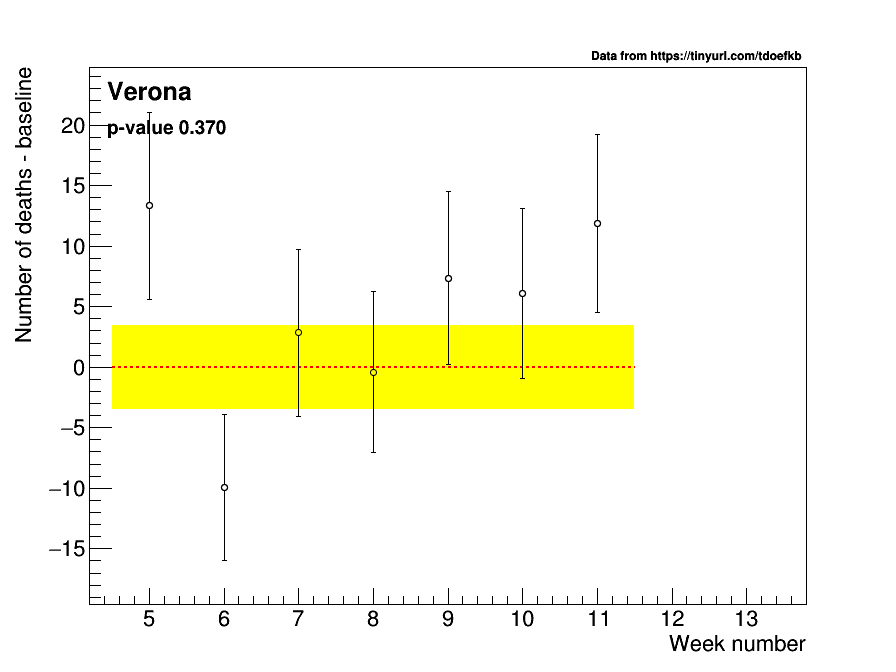

In [16]:

for p in provinces:
    graphs['eccesso_deceduti_%s'%p].Draw("APSAME")
    graphs['eccesso_deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['eccesso_deceduti_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")

    baseline_stdev=graphs['deceduti_%s'%p].GetFunction('fB').GetParError(0)
    box=R.TBox(4.5,-baseline_stdev,11.5,baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(4.5,0,11.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)
    line.Draw()

    graphs['eccesso_deceduti_%s'%p].Draw("PSAME")
    
    f0=R.TF1("f0","pol0",0,graphs['eccesso_deceduti_%s'%p].GetN()+6)
    graphs['eccesso_deceduti_%s'%p].Fit('f0','RB0Q','')
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    if (f0.GetProb()>=1E-3):
        t.DrawLatexNDC(0.12,0.8,'p-value %.3f'%f0.GetProb())
    else:
        t.DrawLatexNDC(0.12,0.8,'p-value < 0.001')

    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathExcess_{:s}".format(p)+ext)



Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Aosta.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Aosta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Aosta.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bari.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bari.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bari.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bologna.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/death_Bologna.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/death_B

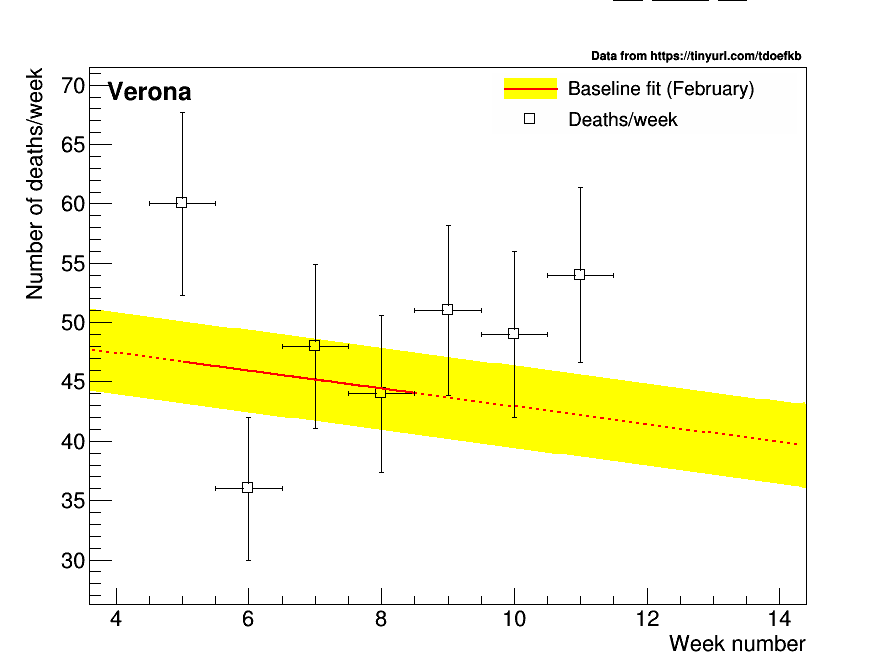

In [17]:
leg=R.TLegend(0.55,0.89,0.89,0.8)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)

for p in provinces:
    leg.Clear()
    graphs['deceduti_%s'%p].Draw("APSAME")
    graphs['deceduti_%s'%p].GetXaxis().SetTitle("Week number")
    graphs['deceduti_%s'%p].GetYaxis().SetTitle("Number of deaths/week")
    
    f2=graphs['deceduti_%s'%p].GetFunction('fB').Clone()
    f2.SetRange(0,5.5+graphs['deceduti_%s'%p].GetN())
    f2.SetLineStyle(2)
    
    #make error band
    xA=graphs['deceduti_%s'%p].GetXaxis()
    xLow=xA.GetBinLowEdge(1)
    xHigh=xA.GetBinUpEdge(xA.GetNbins())
    xS = n.linspace(xLow, xHigh, 100)
    yS = [f2.Eval(x) for x in xS]
    xErr = n.zeros(100)
    yErr = [f2.GetParError(0) for x in xS]
    band=R.TGraphErrors(len(xS),xS,n.asarray(yS),xErr,n.asarray(yErr))
    band.SetFillColor(R.kYellow)
    
    band.Draw('4SAME')
    f2.Draw('LSAME')
    graphs['deceduti_%s'%p].Draw("PSAME")
    
    #auxiliary object for the legend
    aux=graphs['deceduti_%s'%p].Clone('aux')
    aux.SetFillColor(R.kYellow)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    #aux.SetFillStyle(3000)
    leg.AddEntry(aux,'Baseline fit (February)','FL')
    leg.AddEntry(graphs['deceduti_%s'%p],'Deaths/week','P')
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    leg.Draw()
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    c1.RedrawAxis()
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/death_{:s}".format(p)+ext)

Aosta
Bari
Bologna
Bolzano
Brescia
Genova
Messina
Milano
Palermo
Perugia
Potenza
Roma
Torino
Trento
Venezia
Verona
 FCN=165.924 FROM MIGRAD    STATUS=CONVERGED      86 CALLS          87 TOTAL
                     EDM=2.95293e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -5.98908e+01   7.66381e-01   5.91427e-05   1.63646e-02
   2  p1           1.00000e+00   8.69490e-03   5.26137e-04** at limit **
 FCN=244.516 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=3.47755e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.63649e-01   9.77601e-01   7.53832e-05   6.55836e-02
   2  p1           1.00000e+00   2.13853e-03   3.16434e-04** at 

Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Aosta.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Aosta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Aosta.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Bari.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Bari.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Bari.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Bologna.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathDaily_Bologna.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/merid

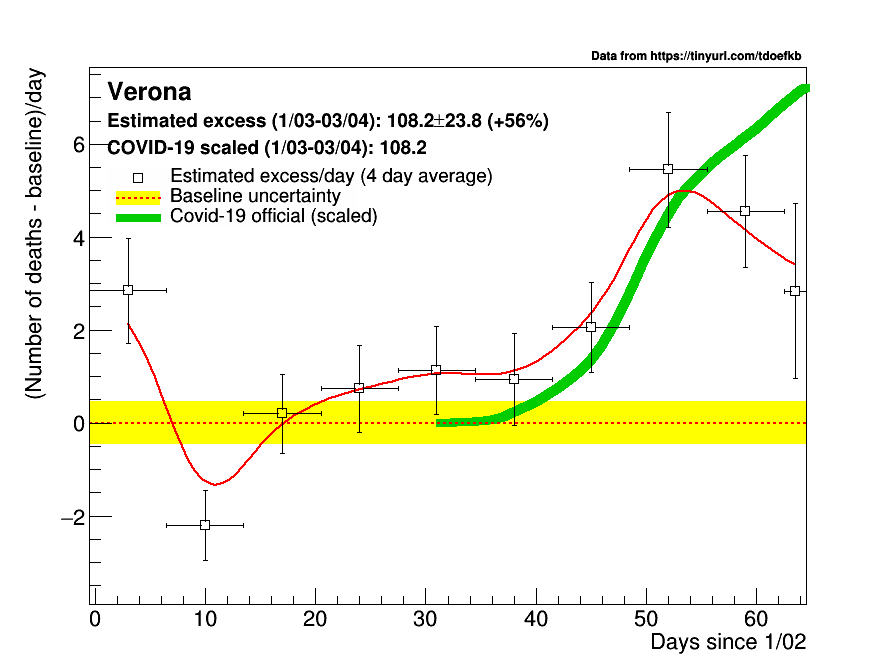

In [28]:
leg=R.TLegend(0.12,0.83,0.4,0.73)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)

for p in provincesDaily:
    leg.Clear()
    print(p)
    #graphs['eccesso_deceduti_giornalieri_%s'%p].Draw("APSAME")
    graphs['deceduti_giornalieri_%s'%p].GetXaxis().SetTitle("Days since 1/02")
    graphs['deceduti_giornalieri_%s'%p].GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['deceduti_giornalieri_%s'%p].GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['deceduti_giornalieri_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")
    graphs['deceduti_giornalieri_%s'%p].Fit('ff','RB+','',0,100)
    rebinned=rebinGraph(graphs['deceduti_giornalieri_%s'%p],4,1)
    rebinned.SetMarkerStyle(25)
    rebinned.SetMarkerSize(1.2)
    rebinned.Draw('AP')
    smoothed=smooth.SmoothSuper(rebinned,'')

    rebinned.GetXaxis().SetTitle("Days since 1/02")
    rebinned.GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetYaxis().SetTitle("Number of deaths/day")

    #baseline_stdev=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').GetParError(0)
    #box=R.TBox(-0.5,-baseline_stdev,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,baseline_stdev)
    #box.SetFillColor(R.kYellow)
    #box.Draw()
    #line=R.TLine(-0.5,0,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,0)
    #line.SetLineColor(R.kRed)
    #line.SetLineStyle(2)
    #line.SetLineWidth(2)
    #make error band
    xA=rebinned.GetXaxis()
    xLow=xA.GetBinLowEdge(1)
    xHigh=xA.GetBinUpEdge(xA.GetNbins())
    
    f2=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').Clone()
    f2.SetRange(xLow,xHigh)
    f2.SetLineStyle(2)
    
    xS = n.linspace(xLow, xHigh, 100)
    yS = [f2.Eval(x) for x in xS]
    xErr = n.zeros(100)
    yErr = [f2.GetParError(0) for x in xS]
    band=R.TGraphErrors(len(xS),xS,n.asarray(yS),xErr,n.asarray(yErr))
    band.SetFillColor(R.kYellow)
    
    band.Draw('4SAME')
    f2.Draw('LSAME')
    graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').Draw('LSAME')
    rebinned.Draw("PSAME")
    
    aux=R.TGraph()
    aux.SetFillColor(R.kYellow)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    aux.SetLineStyle(2)
    leg.AddEntry(rebinned,'4 day average','PL')
    leg.AddEntry(aux,'Baseline model','FL')
    leg.Draw()
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
                   
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    #ar=R.TArrow(29.5,rebinned.GetYaxis().GetBinLowEdge(1)+1,36,rebinned.GetYaxis().GetBinLowEdge(1)+1,0.02,"|>")
    #ar.Draw()
    #t.SetTextSize(0.03)
    #t.DrawLatex(29.5,rebinned.GetYaxis().GetBinLowEdge(1)+1.5,'March')
    
    c1.RedrawAxis()
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathDaily_{:s}".format(p)+ext)

leg=R.TLegend(0.12,0.75,0.4,0.66)
leg.SetBorderSize(0)
leg.SetFillColorAlpha(0,0)
leg.SetTextSize(0.03)        
        
for p in provincesDaily:
    leg.Clear()
    #graphs['eccesso_deceduti_giornalieri_%s'%p].Draw("APSAME")
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetXaxis().SetTitle("Days since 1/02")
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    graphs['eccesso_deceduti_giornalieri_%s'%p].GetYaxis().SetTitle("Number of deaths - baseline")
    graphs['eccesso_deceduti_giornalieri_%s'%p].Fit('ff','RB+','',0,100)
    rebinned=rebinGraph(graphs['eccesso_deceduti_giornalieri_%s'%p],7,1)
    rebinned.SetMarkerStyle(25)
    rebinned.SetMarkerSize(1.2)
    rebinned.Draw('AP')
    smoothed=smooth1.SmoothKern(rebinned,'normal',10)
    smoothed.SetName('smoothed_rebin4')
    rebinned.GetXaxis().SetTitle("Days since 1/02")
    rebinned.GetXaxis().SetLimits(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetXaxis().SetRangeUser(-0.5,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5)
    rebinned.GetYaxis().SetTitle("(Number of deaths - baseline)/day")

    baseline_stdev=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').GetParError(0)
    box=R.TBox(-0.5,-baseline_stdev,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,baseline_stdev)
    box.SetFillColor(R.kYellow)
    box.Draw()
    line=R.TLine(-0.5,0,graphs['deceduti_giornalieri_%s'%p].GetN()-0.5,0)
    line.SetLineColor(R.kRed)
    line.SetLineStyle(2)
    line.SetLineWidth(2)

    #graphs['eccesso_deceduti_giornalieri_%s'%p].Draw("PSAME")
    smoothedExt=smooth.SmoothSuper(graphs['estimated_death_town_%s'%p],'')
    graphs['estimated_death_town_%s'%p].SetLineColor(R.kGreen+1)
    graphs['estimated_death_town_%s'%p].SetLineWidth(8)
    #graphs['estimated_death_town_%s'%p].Draw("LSAME")
    smoothedExt.SetLineColor(R.kGreen+1)
    smoothedExt.SetLineWidth(8)
    smoothedExt.Draw("LSAME")
    line.Draw()
    #f.Draw('LSAME')
    normalDeath=graphs['deceduti_giornalieri_%s'%p].GetFunction('fB').Integral(31,graphs['eccesso_deceduti_giornalieri_%s'%p].GetN()-1)
    totalExcess=integralGraph(graphs['eccesso_deceduti_giornalieri_%s'%p],31)
    expectedExcess=integralGraph(graphs['estimated_death_town_%s'%p],0,graphs['eccesso_deceduti_giornalieri_%s'%p].GetN()-31)
    if(expectedExcess[0]>0):
        ratio=totalExcess[0]/expectedExcess[0]
    else:
        ratio=0
        
    f1=R.TF1('f1','[2]*TMath::Exp((x+[0])/[1])',0,100)
    f1.SetParameter(0,f.GetParameter(0))
    f1.SetParameter(1,f.GetParameter(1))
    f1.SetParameter(2,1/ratio)
    f1.SetLineColor(R.kRed)
    f1.SetLineStyle(2)
    f1.SetLineWidth(2)
    #f1.Draw('LSAME')

    smoothed.SetLineColor(R.kBlack+1)
    smoothed.SetLineWidth(2)
    smoothed.Draw("LSAME")
    rebinned.Draw("PSAME")
    
    aux=R.TGraph()
    aux.SetFillColor(R.kYellow)
    aux.SetLineColor(R.kRed)
    aux.SetLineWidth(2)
    aux.SetLineStyle(2)
    leg.AddEntry(rebinned,'Estimated excess/day (4 day average)','P')
    leg.AddEntry(aux,'Baseline uncertainty','FL')
    leg.AddEntry(smoothedExt,'Covid-19 official (scaled)','L')
    leg.Draw()
    f0=R.TF1("f0","pol0",0,100)
    rebinned1=rebinGraph(graphs['eccesso_deceduti_giornalieri_%s'%p],4,1)
    rebinned1.Fit('f0','0Q+')
    prob=rebinned1.GetFunction('f0').GetProb()
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    #if (prob>=1E-3):
    #    t.DrawLatexNDC(0.12,0.8,'no excess p-value %.3f'%prob)
    #else:
    #    t.DrawLatexNDC(0.12,0.8,'no excess p-value < 0.001')

    totalExcessError=R.TMath.Sqrt(totalExcess[1]**2+(baseline_stdev*35)**2)
    if (normalDeath>0):
        t.DrawLatexNDC(0.12,0.81,'Estimated excess (1/03-03/04): %.1f#pm%.1f'%(totalExcess[0],totalExcessError)+' (+{:.0%})'.format(totalExcess[0]/normalDeath))
        t.DrawLatexNDC(0.12,0.77,'COVID-19 scaled (1/03-03/04): %.1f'%expectedExcess[0])
                   
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    #ar=R.TArrow(29.5,rebinned.GetYaxis().GetBinLowEdge(1)+1,36,rebinned.GetYaxis().GetBinLowEdge(1)+1,0.02,"|>")
    #ar.Draw()
    #t.SetTextSize(0.03)
    #t.DrawLatex(29.5,rebinned.GetYaxis().GetBinLowEdge(1)+1.5,'March')
    
    c1.RedrawAxis()
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathExcessDaily_{:s}".format(p)+ext)

In [19]:
dfIstat.head()

,REG,PROV,COD_PROVCOM,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,DATA_INIZIO_DIFF,SETTIMANA,CLASSE_DI_ETA,MASCHI_2015,...,FEMMINE_2017,FEMMINE_2018,FEMMINE_2019,FEMMINE_2020,TOTALE_2015,TOTALE_2016,TOTALE_2017,TOTALE_2018,TOTALE_2019,TOTALE_2020
0,1,1,1001,Piemonte,Torino,Agliè,1 aprile,01/01-11/01,0-14 anni,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1001,Piemonte,Torino,Agliè,1 aprile,12/01-18/01,0-14 anni,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1001,Piemonte,Torino,Agliè,1 aprile,19/01-25/01,0-14 anni,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1001,Piemonte,Torino,Agliè,1 aprile,26/01-01/02,0-14 anni,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1001,Piemonte,Torino,Agliè,1 aprile,02/02-08/02,0-14 anni,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
regions = n.unique(dfIstat['NOME_REGIONE'])
#weeks=n.unique(dfIstat['SETTIMANA'])
weeks={'01/01-11/01':0 , '01/03-07/03':8, '02/02-08/02':4, '08/03-14/03':9, '09/02-15/02':5,
 '12/01-18/01':1, '15/03-21/03':10, '16/02-22/02':6, '19/01-25/01':2, '23/02-29/02':7,
 '26/01-01/02':3}
ages=n.unique(dfIstat['CLASSE_DI_ETA'])
print(ages)
for w,index in weeks.items():
#    print(index,w)
    dfIstat=dfIstat.replace(w,index)

for a in ages:
    age=a
    index=int(n.where(ages == a)[0])
#    print(index,age)
    dfIstat=dfIstat.replace(age,index)
    
dfIstat.head()

['0-14 anni' '15-64 anni' '65-74 anni' '75 anni e più']


,REG,PROV,COD_PROVCOM,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,DATA_INIZIO_DIFF,SETTIMANA,CLASSE_DI_ETA,MASCHI_2015,...,FEMMINE_2017,FEMMINE_2018,FEMMINE_2019,FEMMINE_2020,TOTALE_2015,TOTALE_2016,TOTALE_2017,TOTALE_2018,TOTALE_2019,TOTALE_2020
0,1,1,1001,Piemonte,Torino,Agliè,1 aprile,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1001,Piemonte,Torino,Agliè,1 aprile,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1001,Piemonte,Torino,Agliè,1 aprile,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1001,Piemonte,Torino,Agliè,1 aprile,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1001,Piemonte,Torino,Agliè,1 aprile,4,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
dfDeaths={}
for p in regions:
    print('=======',p)
    dfDeaths[p]=dfIstat[dfIstat['NOME_REGIONE']==p]
    for w in range(len(weeks)):
            print(p,w,dfDeaths[p].loc[dfDeaths[p]['SETTIMANA']==w]['TOTALE_2020'].sum())
        
#    dfDaily[p]=dfDaily[p].drop(columns=['Town'])
#    dfDaily[p]=dfDaily[p].transpose()
#    dfDaily[p].columns=['number_of_deaths']
#    dfDaily[p]['number_of_deaths']=dfDaily[p]['number_of_deaths'].astype(float)

======= Abruzzo
Abruzzo 0 66
Abruzzo 1 44
Abruzzo 2 48
Abruzzo 3 55
Abruzzo 4 44
Abruzzo 5 46
Abruzzo 6 39
Abruzzo 7 52
Abruzzo 8 57
Abruzzo 9 56
Abruzzo 10 66
======= Basilicata
Basilicata 0 27
Basilicata 1 14
Basilicata 2 6
Basilicata 3 14
Basilicata 4 10
Basilicata 5 17
Basilicata 6 7
Basilicata 7 17
Basilicata 8 10
Basilicata 9 20
Basilicata 10 16
======= Calabria
Calabria 0 41
Calabria 1 17
Calabria 2 28
Calabria 3 30
Calabria 4 26
Calabria 5 24
Calabria 6 15
Calabria 7 24
Calabria 8 20
Calabria 9 38
Calabria 10 33
======= Campania
Campania 0 86
Campania 1 50
Campania 2 66
Campania 3 61
Campania 4 55
Campania 5 51
Campania 6 54
Campania 7 59
Campania 8 62
Campania 9 64
Campania 10 65
======= Emilia-Romagna
Emilia-Romagna 0 1020
Emilia-Romagna 1 601
Emilia-Romagna 2 561
Emilia-Romagna 3 601
Emilia-Romagna 4 618
Emilia-Romagna 5 627
Emilia-Romagna 6 614
Emilia-Romagna 7 683
Emilia-Romagna 8 773
Emilia-Romagna 9 1088
Emilia-Romagna 10 1442
======= Friuli-Venezia Giulia
Friuli-Venezia

In [22]:
dfByTownAgeWeekly.head()

,citta,settimana,all,6574,7584,85p
0,AOSTA,5,5,2,0,3
1,AOSTA,6,9,1,2,6
2,AOSTA,7,11,3,3,5
3,AOSTA,8,10,2,1,6
4,AOSTA,9,11,1,3,6


In [23]:
dfByAge={}

provinces = n.unique(dfByTownAgeWeekly['citta'])
for p in provinces:
    dfByAge[p]=dfByTownAgeWeekly[dfByTownAgeWeekly['citta']==p]
    dfByAge[p]=dfByAge[p].drop(columns=['citta'])
    #dfByAge[p]=dfByAge[p].transpose()
    #dfByAge[p].columns=['number_of_deaths']
    dfByAge[p]=dfByAge[p].set_index('settimana')
    dfByAge[p].columns=['All','65m74','74m85','85p']
    print(p,len(dfByAge[p]))

AOSTA 7
BARI 7
BOLOGNA 7
BOLZANO 7
BRESCIA 7
CIVITAVECCHIA 7
FROSINONE 7
GENOVA 7
MESSINA 7
MILANO 7
PALERMO 7
PERUGIA 7
POTENZA 7
ROMA 7
TORINO 7
VENEZIA 7
VERONA 7


In [24]:
dfByAge['MILANO'].head()

,All,65m74,74m85,85p
settimana,,,,
5,239,17,70,131
6,231,28,53,135
7,231,28,58,119
8,243,31,62,130
9,245,21,67,133


In [25]:
for p in provinces:
    for c in dfByAge[p].columns:
        graphs['deceduti_%s_%s'%(p,c)]=R.TGraphErrors()
        graphs['deceduti_%s_%s'%(p,c)].SetName('deceduti_%s_%s'%(p,c))
                                    
        for i,ni in enumerate(dfByAge[p][c]):
            #print(i,ni)
            scale=1.
            graphs['deceduti_%s_%s'%(p,c)].SetPoint(i,i+5,ni*scale)
            graphs['deceduti_%s_%s'%(p,c)].SetPointError(i,0.5,R.TMath.Sqrt(ni)*scale)
        graphs['deceduti_%s_%s'%(p,c)].SetLineColor(R.kBlack)
        graphs['deceduti_%s_%s'%(p,c)].SetMarkerColor(R.kBlack)
        graphs['deceduti_%s_%s'%(p,c)].SetMarkerStyle(25)
        graphs['deceduti_%s_%s'%(p,c)].SetMarkerSize(1.3)
        #Temporary: using as baseline fit of February data
        fB=R.TF1('fB','[0]*(1-0.0023*7*(x-5))',0,100)
        graphs['deceduti_%s_%s'%(p,c)].Fit('fB','RQB+','',5,8.5)

        graphs['eccesso_deceduti_%s_%s'%(p,c)]=R.TGraphErrors()
        graphs['eccesso_deceduti_%s_%s'%(p,c)].SetName('eccesso_deceduti_%s_%s'%(p,c))
        for i,ni in enumerate(dfByAge[p][c]):
            scale=1.
            #if (i==len(dfByAge[p][c])-1):
            #    scale=7./lastWeekDays[p]
            graphs['eccesso_deceduti_%s_%s'%(p,c)].SetPoint(i,i+5,ni*scale-graphs['deceduti_%s_%s'%(p,c)].GetFunction('fB').Eval(i+5))
            graphs['eccesso_deceduti_%s_%s'%(p,c)].SetPointError(i,0,R.TMath.Sqrt(ni)*scale)
        graphs['eccesso_deceduti_%s_%s'%(p,c)].SetLineColor(R.kBlack)
        graphs['eccesso_deceduti_%s_%s'%(p,c)].SetMarkerColor(R.kBlack)
        graphs['eccesso_deceduti_%s_%s'%(p,c)].SetMarkerStyle(24)
        graphs['eccesso_deceduti_%s_%s'%(p,c)].SetMarkerSize(0.9)

Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_AOSTA_All.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_AOSTA_All.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_AOSTA_All.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_AOSTA_65m74.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_AOSTA_65m74.png has been created
Info in <TCanvas::SaveAs>: ROOT file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_AOSTA_65m74.root has been created
Info in <TCanvas::Print>: pdf file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_AOSTA_74m85.pdf has been created
Info in <TCanvas::Print>: png file /Users/meridian/cernbox/www/plots/COVID19_DA/deathExcess_AOSTA_74m85.png has been created


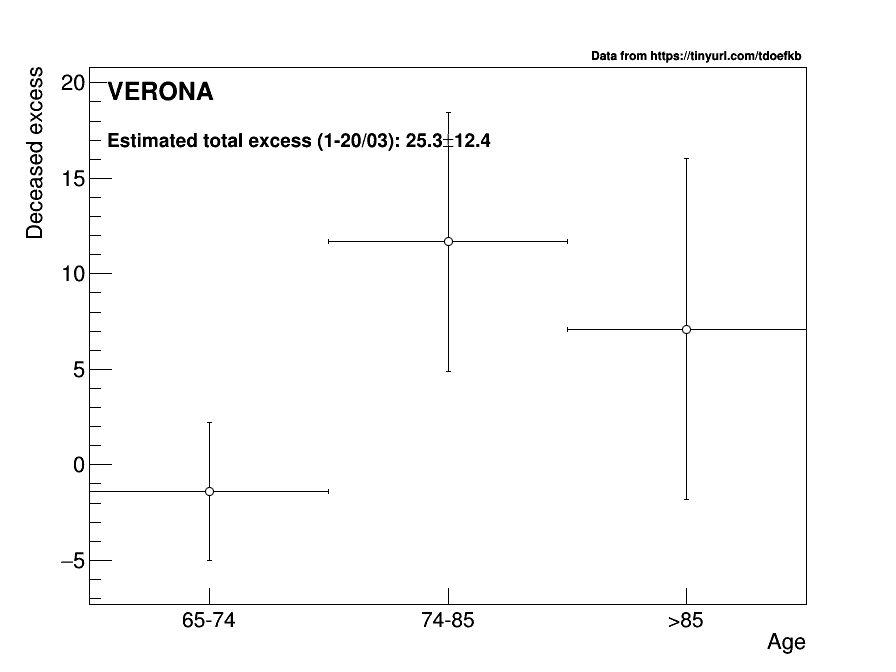

In [26]:
R.gStyle.SetOptTitle(0)

for p in provinces:
    graphs['fractionOfExcess_%s'%p]=R.TGraphErrors()
    graphs['eccesso_deceduti_byAge_%s'%p]=R.TGraphErrors()
    totalExcess={}
    for c in dfByAge[p].columns:
        graphs['eccesso_deceduti_%s_%s'%(p,c)].Draw("APSAME")
        graphs['eccesso_deceduti_%s_%s'%(p,c)].GetXaxis().SetTitle("Week number")
        graphs['eccesso_deceduti_%s_%s'%(p,c)].GetYaxis().SetTitle("Number of deaths - baseline")

        baseline_stdev=graphs['deceduti_%s_%s'%(p,c)].GetFunction('fB').GetParError(0)
        box=R.TBox(4.5,-baseline_stdev,11.5,baseline_stdev)
        box.SetFillColor(R.kYellow)
        box.Draw()
        line=R.TLine(4.5,0,11.5,0)
        line.SetLineColor(R.kRed)
        line.SetLineStyle(2)
        line.SetLineWidth(2)
        line.Draw()

        graphs['eccesso_deceduti_%s_%s'%(p,c)].Draw("PSAME")
    
        f0=R.TF1("f0","pol0",0,graphs['eccesso_deceduti_%s_%s'%(p,c)].GetN()+6)
        graphs['eccesso_deceduti_%s_%s'%(p,c)].Fit('f0','RB0Q','')
        t.SetTextSize(0.04)
        t.DrawLatexNDC(0.12,0.85,p)
        t.SetTextSize(0.03)
        if (f0.GetProb()>=1E-3):
            t.DrawLatexNDC(0.12,0.8,'p-value %.3f'%f0.GetProb())
        else:
            t.DrawLatexNDC(0.12,0.8,'p-value < 0.001')

        totalExcess[c]=integralGraph(graphs['eccesso_deceduti_%s_%s'%(p,c)],4)
        t.DrawLatexNDC(0.12,0.76,'Estimated excess (1-20/03): %.1f#pm%.1f'%(totalExcess[c][0],totalExcess[c][1]))
        
        t.SetTextSize(0.02)
        t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
        
        c1.Draw()
        for ext in ['.pdf','.png','.root']:
            c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathExcess_{:s}_{:s}".format(p,c)+ext)

    ip=0
    for ic,c in enumerate(dfByAge[p].columns):
        
        if (c=='All'):
            continue
        frac=totalExcess[c][0]/totalExcess['All'][0]
        #print(ip)
        graphs['fractionOfExcess_%s'%p].SetPoint(ip,ip+1,frac)
        graphs['fractionOfExcess_%s'%p].SetPointError(ip,0.5,R.TMath.Sqrt(frac*(1-frac)/totalExcess['All'][0]))
        graphs['eccesso_deceduti_byAge_%s'%p].SetPoint(ip,ip+1,totalExcess[c][0])
        graphs['eccesso_deceduti_byAge_%s'%p].SetPointError(ip,0.5,totalExcess[c][1])
        ip+=1
    
    xLabels=['65-74','74-85','>85']   
    graphs['fractionOfExcess_%s'%p].SetMarkerStyle(24)
    graphs['fractionOfExcess_%s'%p].SetMarkerSize(1.2)
 
    
    a=R.TH2F('a','a',graphs['fractionOfExcess_%s'%p].GetN(),0.5,graphs['fractionOfExcess_%s'%p].GetN()+0.5,10,0,1.)
    a.GetYaxis().SetTitle('Deceased excess fraction')
    for ic,c in enumerate(dfByAge[p].columns):
        if (c=='All'):
            continue
        a.GetXaxis().SetBinLabel(ic,xLabels[ic-1]) 
    a.GetXaxis().SetLabelSize(0.05)
    a.GetXaxis().SetTitle('Age')
    a.SetStats(0)
    a.Draw()
    graphs['fractionOfExcess_%s'%p].Draw('PSAME')
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.78,'Estimated total excess (1-20/03): %.1f#pm%.1f'%(totalExcess[c][0],totalExcess[c][1]))    
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathFractionExcessByAge_{:s}".format(p)+ext)
 
    graphs['eccesso_deceduti_byAge_%s'%p].SetMarkerStyle(24)
    graphs['eccesso_deceduti_byAge_%s'%p].SetMarkerSize(1.2)
    graphs['eccesso_deceduti_byAge_%s'%p].GetYaxis().SetTitle('Dececeased excess')
    #graphs['eccesso_deceduti_byAge_%s'%p]].GetYaxis().SetLimits(0,0.7)
    #graphs['eccesso_deceduti_byAge_%s'%p]].GetYaxis().SetRangeUser(0,0.7)
    graphs['eccesso_deceduti_byAge_%s'%p].Draw('AP')
    
    yA=graphs['eccesso_deceduti_byAge_%s'%p].GetYaxis()
    yLow=yA.GetBinLowEdge(1)
    yHigh=yA.GetBinUpEdge(yA.GetNbins())
    
    a=R.TH2F('a','a',graphs['fractionOfExcess_%s'%p].GetN(),0.5,graphs['fractionOfExcess_%s'%p].GetN()+0.5,10,yLow,yHigh)
    a.GetYaxis().SetTitle('Deceased excess')
    for ic,c in enumerate(dfByAge[p].columns):
        if (c=='All'):
            continue
        a.GetXaxis().SetBinLabel(ic,xLabels[ic-1]) 
    a.GetXaxis().SetLabelSize(0.05)
    a.GetXaxis().SetTitle('Age')
    a.SetStats(0)
    a.Draw()
    graphs['eccesso_deceduti_byAge_%s'%p].Draw('PSAME')
    
    t.SetTextSize(0.04)
    t.DrawLatexNDC(0.12,0.85,p)
    t.SetTextSize(0.03)
    t.DrawLatexNDC(0.12,0.78,'Estimated total excess (1-20/03): %.1f#pm%.1f'%(totalExcess['All'][0],totalExcess['All'][1]))    
    t.SetTextSize(0.02)
    t.DrawLatexNDC(0.66,0.91,'Data from https://tinyurl.com/tdoefkb')
    
    c1.Draw()
    for ext in ['.pdf','.png','.root']:
        c1.SaveAs("~/cernbox/www/plots/COVID19_DA/deathExcessByAge_{:s}".format(p)+ext)

In [27]:
fOut=R.TFile('~/cernbox/www/plots/COVID19_DA/graphs.root','RECREATE')
for o,g in graphs.items():
    g.Write()
fOut.Write()
fOut.Close()